In [1]:
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")
from src.util import dt_to_Ls, dt_to_mtfnc

import marstime as mt

In [2]:
#Some constants
g = 3.71 #m/s^2 surface gravity
M_Mars =  0.64171e+24 #kg
R_Mars = 3396.2e+3 #m
Grav = 6.67408e-11 #m^3 kg^-1 s^-2
amu = 1.660539040e-27 #kg
kboltz = 1.38064852e-23 #J/K

In [3]:
H_pieces = []
for year in [2015, 2016, 2017, 2018, 2019]:
    H_pieces.append(pd.read_csv(f"../output/{year}_H.csv"))
H = pd.concat(H_pieces)

In [4]:
exo_pieces = []
for year in [2015, 2016, 2017, 2018, 2019]:
    exo_pieces.append(pd.read_csv(f"../output/{year}_exo.csv"))
exo = pd.concat(exo_pieces)

In [5]:
hp_pieces = []
for year in [2015, 2016, 2017, 2018, 2019]:
    hp_pieces.append(pd.read_csv(f"../output/{year}_hp.csv"))
hp = pd.concat(hp_pieces)

In [6]:
peri = pd.read_csv(f"../output/peri.csv", parse_dates=["t_utc"])

In [7]:
data = pd.merge(H, peri, on="orbit")
data = pd.merge(data, exo, on="orbit")
data = pd.merge(data, hp, on="orbit")

In [8]:
data["t_utc"].min(), data["t_utc"].max()

(Timestamp('2015-02-11 03:48:50'), Timestamp('2020-01-01 01:14:46'))

In [9]:
#Constants
amu = 1.66053e-27   #1 amu (kg)
g = 3.71/1000 #km/s^2
kboltz = 1.3806488e-23/1000**2 #boltzmann constant (km^2 kg s^-2 K^-1)

def LossFrac(R3836,inv=False):
    R3836 = np.asarray(R3836,dtype=float)
    #38/36 ratios
    r0 = 5.3**-1
    r = 4.2**-1
    if not inv:
        f =  (r/r0)**(1/(R3836-1)) #fraction remaining
        return (1 - f)*100 #percent loss
    elif inv:
        #R3836 now percent loss
        f = 1 - R3836/100. #frac remaining
        return np.log(r/(r0))/np.log(f)+1

def R3836_retH(FracFac,dz):
    FracFac = np.asarray(FracFac,dtype=float)
    dz = np.asarray(dz,dtype=float)
    return -dz/(20*np.log(FracFac))

In [10]:
#Model LossFrac
model_ps = [93,80,65,57,51,43,36]
model_zT = np.array([0.1,0.2,0.3,0.4,0.5,0.7,1.1])
model_Rs = np.exp(-2.*g*model_zT/kboltz*amu)
percents = np.arange(30,100,10)
fracs = LossFrac(percents,inv=True)
seps = np.linspace(0,200,100)

In [11]:
import matplotlib
from matplotlib import rcParams
rcParams['font.sans-serif'] = ['Times New Roman']
#rcParams['font.family'] = 'sans-serif'
font = {'family' : 'sans-serif',
        'size'   : 14}
matplotlib.rc('font', **font)

In [12]:
data.head().columns
data["MY"] = data["t_utc"].apply(dt_to_mtfnc, args=(mt.Clancy_Year,))
data[["t_utc"]].tail()

,t_utc
8123,2019-12-31 07:09:12
8124,2019-12-31 10:46:17
8125,2019-12-31 14:23:26
8126,2019-12-31 18:00:34
8127,2020-01-01 01:14:46


In [13]:
data["Perc_loss"] = LossFrac(np.exp((data["exo_alt"]-data["hp_alt"])/(20*data["H_Ar"]))**-1)
data["Perc_loss"].min(), data["Perc_loss"].max()

check_p = data[(data["Perc_loss"] > 0) & (data["Perc_loss"] < 100)]

In [14]:
(data["exo_alt"] - data["hp_alt"]).median(), data["H_Ar"].median()

(49.48080383364281, 10.492432449316263)

In [15]:
check_p_roll = check_p.sort_values("t_utc").set_index("t_utc").rolling(window="30D", min_periods=10).mean()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


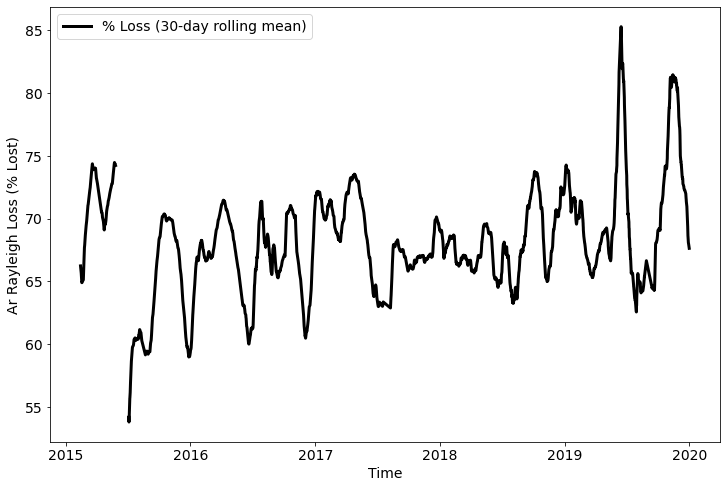

In [16]:
plt.figure(figsize=(12, 8))
#plt.plot(check_p["t_utc"], check_p["Perc_loss"])
plt.plot(check_p_roll.index, check_p_roll["Perc_loss"], label="% Loss (30-day rolling mean)", color="k", lw=3)

plt.xlabel("Time")
plt.ylabel("Ar Rayleigh Loss (% Lost)")
plt.legend(loc=2)

#plt.twinx()
#plt.plot(check_p_roll.index, check_p_roll["sza"], label="SZA", c="lightblue", ls="--")

#plt.plot(check_p["t_utc"], check_p["Ls"], label="Ls", c="r", ls="--")

#plt.ylabel("SZA")
#plt.legend()

#plt.savefig("../../Desktop/Loss_time.png", dpi=300)

plt.show()

In [17]:
orig = data[data["t_utc"]< dt.datetime(2016, 7, 1)]
new = data[data["t_utc"]>dt.datetime(2016, 7, 1)]

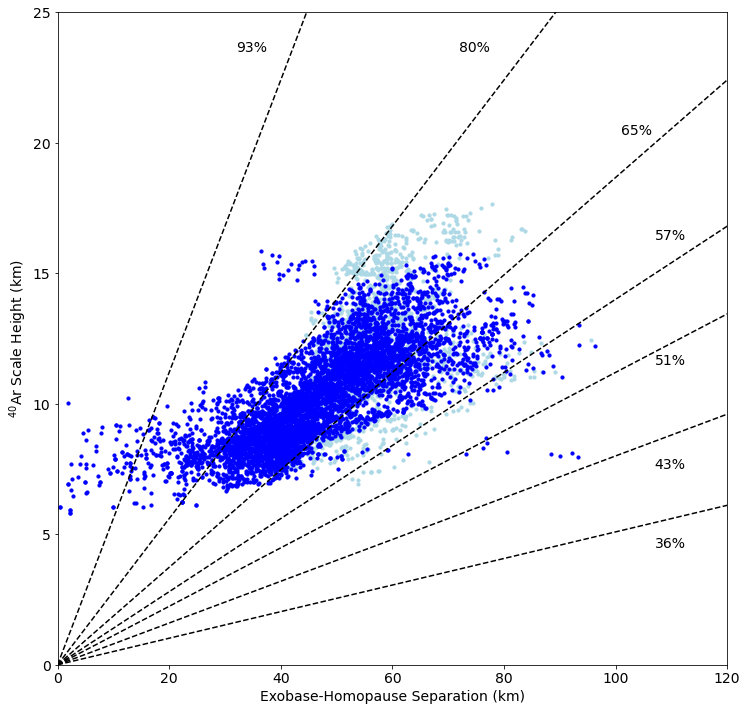

In [18]:
model_xtxt=[137-30,137-30,137-30,137-30,116-15,72,32][::-1]
model_ytxt=[5.5-1,9.5-2,14.5-3,21-4.7,23.5-3.2,23.5,23.5][::-1]

plt.figure(figsize=(12, 12))

for i,mR in enumerate(model_Rs):
    model_H = R3836_retH(mR,seps)
    #print 'z/H: ',seps[1]/model_H[1], model_zT[i]*(40*amu*g)/kboltz, model_zT[i]
    plt.plot(seps,model_H,'k--',lw=1.5,label=model_ps[i])
    plt.annotate(str(model_ps[i])+'%',(model_xtxt[i],model_ytxt[i]),size=14,color='k')

plt.scatter(orig["exo_alt"] - orig["hp_alt"], orig["H_Ar"], s=10, c="lightblue")
plt.scatter(new["exo_alt"] - new["hp_alt"], new["H_Ar"], s=10, c="blue")
    
plt.xlim(0, 120)
plt.ylim(0, 25)

#Axes, labels, etc
plt.xlabel('Exobase-Homopause Separation (km)',fontsize=14)
plt.ylabel(r'$^{40}$Ar Scale Height (km)',fontsize=14)

plt.show()

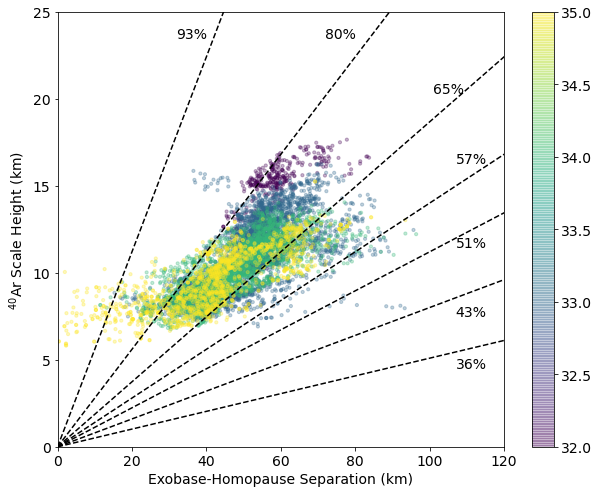

In [19]:
model_xtxt=[137-30,137-30,137-30,137-30,116-15,72,32][::-1]
model_ytxt=[5.5-1,9.5-2,14.5-3,21-4.7,23.5-3.2,23.5,23.5][::-1]

fig = plt.figure(figsize=(10, 8))

for i,mR in enumerate(model_Rs):
    model_H = R3836_retH(mR,seps)
    #print 'z/H: ',seps[1]/model_H[1], model_zT[i]*(40*amu*g)/kboltz, model_zT[i]
    plt.plot(seps,model_H,'k--',lw=1.5,label=model_ps[i])
    plt.annotate(str(model_ps[i])+'%',(model_xtxt[i],model_ytxt[i]),size=14,color='k')

smap = plt.scatter(data["exo_alt"] - data["hp_alt"], data["H_Ar"], s=10, c=data["MY"], alpha=0.3)
    
plt.xlim(0, 120)
plt.ylim(0, 25)

#Axes, labels, etc
plt.xlabel('Exobase-Homopause Separation (km)',fontsize=14)
plt.ylabel(r'$^{40}$Ar Scale Height (km)',fontsize=14)

plt.colorbar()

plt.show()

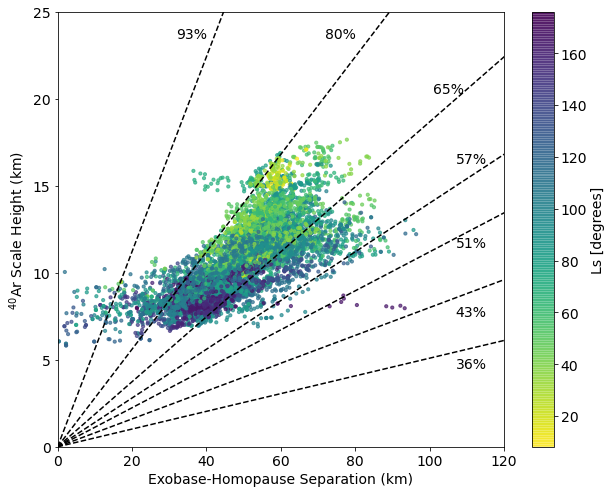

In [20]:
model_xtxt=[137-30,137-30,137-30,137-30,116-15,72,32][::-1]
model_ytxt=[5.5-1,9.5-2,14.5-3,21-4.7,23.5-3.2,23.5,23.5][::-1]

fig = plt.figure(figsize=(10, 8))

for i,mR in enumerate(model_Rs):
    model_H = R3836_retH(mR,seps)
    #print 'z/H: ',seps[1]/model_H[1], model_zT[i]*(40*amu*g)/kboltz, model_zT[i]
    plt.plot(seps,model_H,'k--',lw=1.5,label=model_ps[i])
    plt.annotate(str(model_ps[i])+'%',(model_xtxt[i],model_ytxt[i]),size=14,color='k')

smap = plt.scatter(data["exo_alt"] - data["hp_alt"], data["H_Ar"], s=10, c=data["sza"], alpha=0.7, cmap="viridis_r")
    
plt.xlim(0, 120)
plt.ylim(0, 25)

#Axes, labels, etc
plt.xlabel('Exobase-Homopause Separation (km)',fontsize=14)
plt.ylabel(r'$^{40}$Ar Scale Height (km)',fontsize=14)

plt.colorbar(label="Ls [degrees]")

#plt.savefig("../../Desktop/H_sep_loss.png", dpi=300)

plt.show()

(60.0, 150.0)

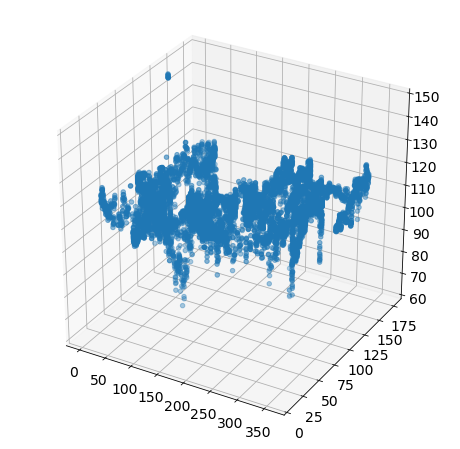

In [197]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Ls"], data["sza"], data["hp_alt"])

ax.set_zlim(60, 150)

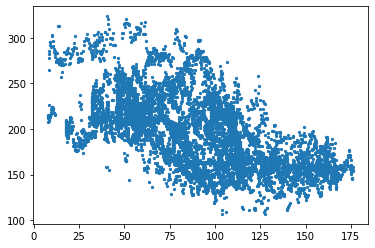

In [7]:
plt.figure()
plt.scatter(data["sza"], (data["H_Ar"]*1000/kboltz*(40*amu*g)), s=5)
plt.show()

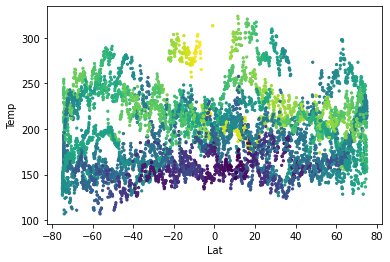

In [8]:
plt.figure()
plt.scatter(
    data["lat"], 
    (data["H_Ar"]*1000/kboltz*(40*amu*g)),
    c=data["sza"],
    cmap="viridis_r",
    s=5
)
plt.xlabel("Lat")
plt.ylabel("Temp")
plt.show()

In [9]:
dusty = data[(data["Ls"]>180) & (data["Ls"]<300)]

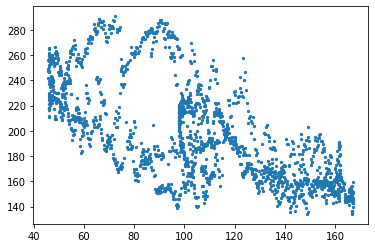

In [10]:
plt.figure()
plt.scatter(dusty["sza"], (dusty["H_Ar"]*1000/kboltz*(40*amu*g)), s=5)
plt.show()

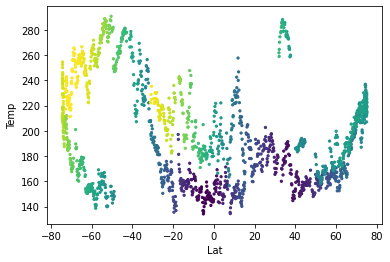

In [11]:
plt.figure()
plt.scatter(
    dusty["lat"], 
    (dusty["H_Ar"]*1000/kboltz*(40*amu*g)),
    c=dusty["sza"],
    cmap="viridis_r",
    s=5
)
plt.xlabel("Lat")
plt.ylabel("Temp")
plt.show()

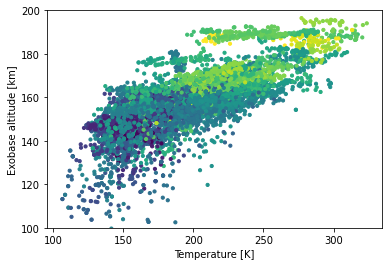

In [12]:
plt.figure()
plt.scatter( 
    (data["H_Ar"]*1000/kboltz*(40*amu*g)),
    data["exo_alt"],
    s=10,
    c=data["sza"],
    cmap="viridis_r"
)
plt.ylim(100,200)
plt.xlabel("Temperature [K]")
plt.ylabel("Exobase altitude [km]")
plt.show()

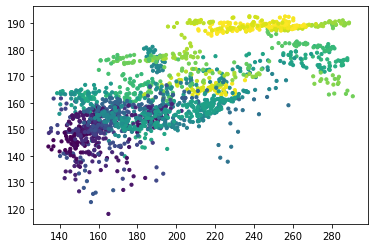

In [13]:
plt.figure()
plt.scatter( 
    (dusty["H_Ar"]*1000/kboltz*(40*amu*g)),
    dusty["exo_alt"],
    s=10,
    c=dusty["sza"],
    cmap="viridis_r"
)
plt.show()

In [14]:
data.columns

Index(['orbit', 'H_Ar', 'fit_slope_Ar', 'fit_intercept_Ar', 'score_Ar', 'H_N2',
       'fit_slope_N2', 'fit_intercept_N2', 'score_N2', 'H_CO2',
       'fit_slope_CO2', 'fit_intercept_CO2', 'score_CO2', 'n_orbits_x',
       'max_alt', 't_utc', 't_unix', 'alt', 'lst', 'long', 'lat', 'sza', 'Ls',
       'exo_alt', 'fit_slope', 'fit_intercept', 'n_orbits_y'],
      dtype='object')

In [15]:
data["t_utc"].apply(dt_to_Ls)

0       289.163574
1       289.280053
2       289.396485
3       289.512849
4       289.629187
           ...    
8123    128.495454
8124    128.567639
8125    128.639860
8126    128.712091
8127    128.856577
Name: t_utc, Length: 8128, dtype: float64

In [25]:
data["MY"] = data["t_utc"].apply(dt_to_mtfnc, args=(mt.Clancy_Year,))

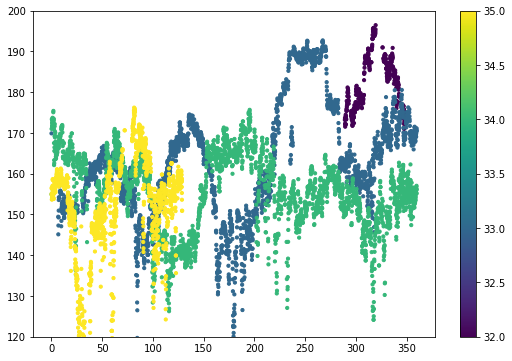

In [26]:
plt.figure(figsize=(9, 6))
plt.scatter(data["Ls"], data["exo_alt"], c=data["MY"], s=10)
plt.colorbar()
plt.ylim(120,200)
plt.show()

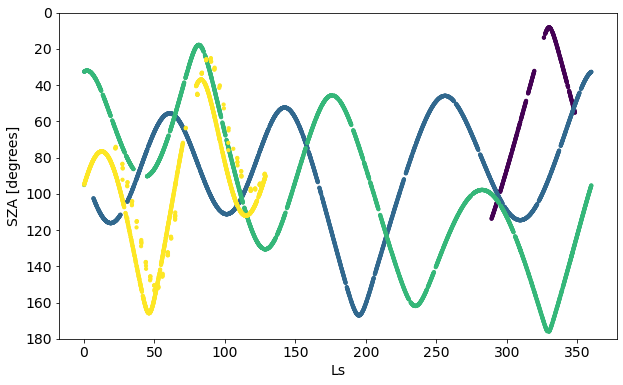

In [232]:
plt.figure(figsize=(10, 6))
plt.scatter(data["Ls"], data["sza"], c=data["MY"], s=10)
plt.xlabel("Ls")
plt.ylabel("SZA [degrees]")
#plt.colorbar()
plt.ylim(180,0)

plt.savefig("../../Desktop/Ls_sza.png", dpi=300)

plt.show()

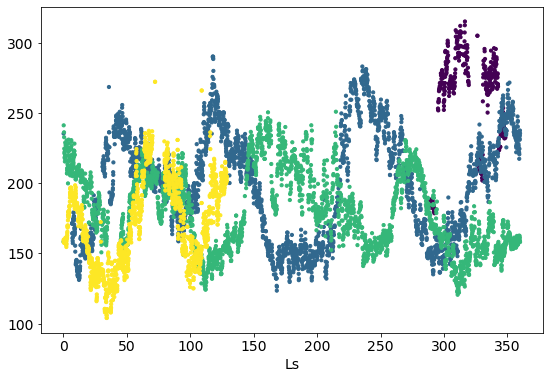

In [21]:
plt.figure(figsize=(9, 6))
plt.scatter(data["Ls"], data["H_Ar"]*(40*g*amu)/kboltz, c=data["MY"], s=10)
plt.xlabel("Ls")
#plt.ylabel("Ar Scale Height [km]")
#plt.colorbar()
plt.show()

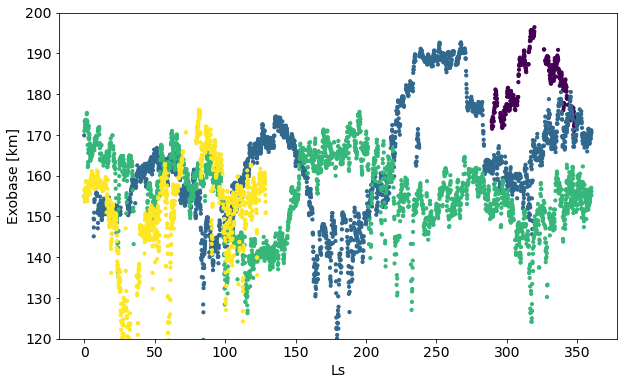

In [235]:
plt.figure(figsize=(10, 6))
plt.scatter(data["Ls"], data["exo_alt"], c=data["MY"], s=10, label="Homopause")
plt.ylim(120, 200)
plt.xlabel("Ls")
plt.ylabel("Exobase [km]")
#plt.colorbar()
plt.show()

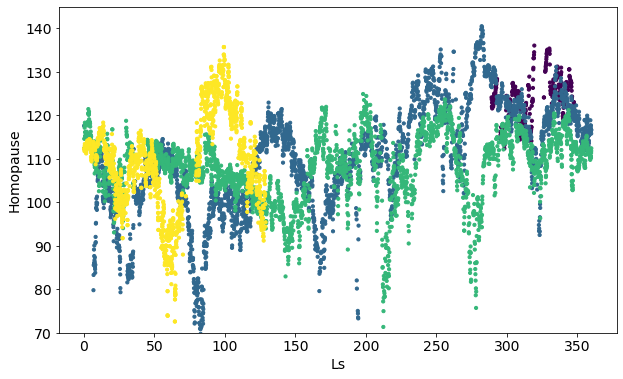

In [220]:
plt.figure(figsize=(10, 6))
plt.scatter(data["Ls"], data["hp_alt"], c=data["MY"], s=10, label="Homopause")
plt.ylim(70, 145)
plt.xlabel("Ls")
plt.ylabel("Homopause [km]")
#plt.colorbar()
plt.show()

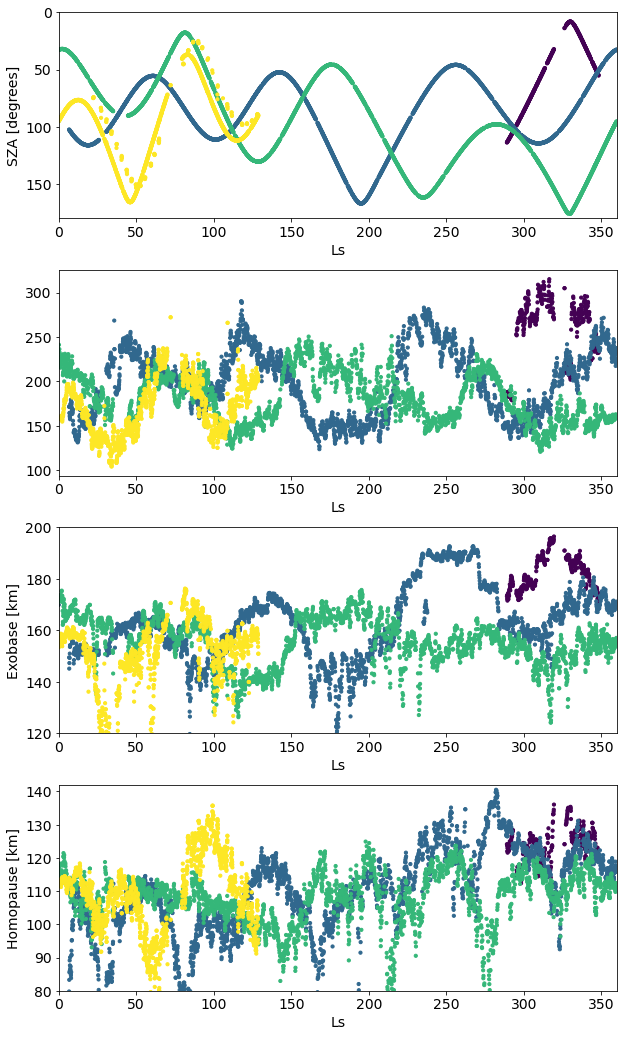

In [22]:
fig, ax = plt.subplots(4, 1, figsize=(10,18))

ax[0].scatter(data["Ls"], data["sza"], c=data["MY"], s=10)
#plt.xlabel("Ls")
ax[0].set_ylabel("SZA [degrees]")
#plt.colorbar()
ax[0].set_ylim(180,0)
ax[0].set_xlabel("Ls")
ax[0].set_xlim(0, 360)

ax[1].scatter(data["Ls"], data["H_Ar"]*(40*g*amu)/kboltz, c=data["MY"], s=10)
#ax[1].set_ylabel("Ar Scale Height [km]")
ax
ax[1].set_xlabel("Ls")
ax[1].set_xlim(0, 360)

ax[2].scatter(data["Ls"], data["exo_alt"], c=data["MY"], s=10, label="Homopause")
ax[2].set_ylim(120, 200)
ax[2].set_ylabel("Exobase [km]")
ax[2].set_xlabel("Ls")
ax[2].set_xlim(0, 360)

ax[3].scatter(data["Ls"], data["hp_alt"], c=data["MY"], s=10, label="Homopause")
ax[3].set_ylim(80, 142)
ax[3].set_xlabel("Ls")
ax[3].set_ylabel("Homopause [km]")
ax[3].set_xlim(0, 360)

plt.subplots_adjust(hspace=0.25)

#plt.savefig("../../Desktop/SZA_Ls.png", dpi=300)

plt.show()

In [ ]:
plt.figure()


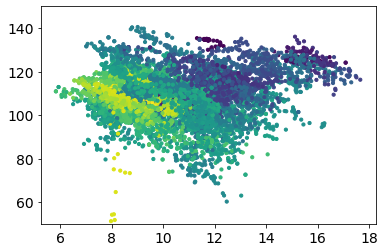

In [201]:
plt.figure()
plt.scatter(data["H_Ar"], data["hp_alt"], s=10, c=data["sza"])
plt.ylim(50, 150)
plt.show()

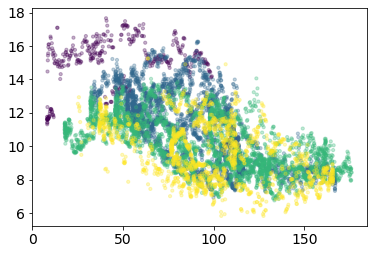

In [206]:
plt.figure()
plt.scatter(data["sza"], data["H_Ar"], s=10, c=data["MY"], alpha=0.3)
plt.show()